20
Time: 0.0017981529235839844 s for 1 molecules with 20 atoms


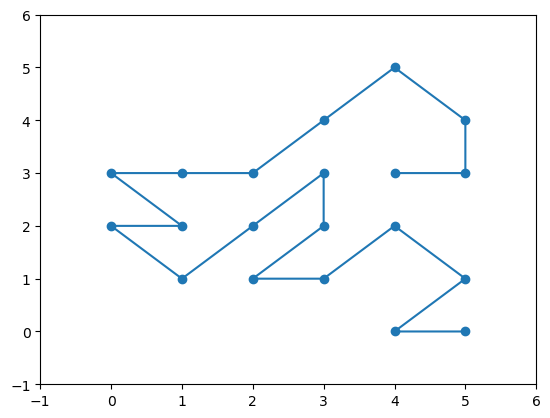

In [51]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

start_time = time.time() # Starting a timer

class System: # The array within which the molecules will sit
    
    def __init__(self, mol_len, num_mols, atom_sequence = 0, density = 1): # Default density is 1 gram per cm^3
        self.mol_len = mol_len
        self.num_mols = num_mols
        self.atom_sequence = atom_sequence
        self.density = density
        self.all_paths = []
        self.sys_state = []
        self.sys_hist = np.array([])
        self.array = np.array([0])
        self.box_length = 0
        self.rollback = (5 + int(np.ceil(self.mol_len / 1000)))
        self.rollback_count = 0
        self.mega_undo_count = 0
        self.pos = []
        self.pos_hist = []
        self.temp_array = np.array([])
        self.finished_mols = np.array([])
        self.mol_pos = []
        

    def save(self, position):
        """Saves the system such that it can be rolled back."""
        self.sys_state = np.copy(self.array)
        self.pos = position
        np.append(self.sys_hist, self.sys_state)
        np.append(self.pos_hist, self.pos)
        return position

    # def temp_save(self, position):
    #     """Saves the system in the temporary loop such that it can be rolled back."""
    #     self.temp_array([position[0], position[1]]) = 1
        
    #     return position

    def undo(self, position):
        """Returns system state back to before the random moves were made."""
        self.array = np.copy(self.sys_state)
        position = self.pos
        return position        

    def mega_undo(self, position):
        """Reverts system state back to a previous version."""
        if len(self.sys_hist) > 0:
            self.sys_state = self.sys_hist[-1]
            self.array = self.sys_state
            self.sys_hist = self.sys_hist[:-1]
            position = self.pos_hist[-1]
            self.pos_hist = self.pos_hist[-1]
        return position

    def save_mol(self, position):
        self.finished_mols = np.copy(self.array)
        self.mol_pos = position

    def undo_mol(self, position):
        if len(self.finished_mols) > 0:
            self.array = np.copy(self.finished_mols)
            position = self.mol_pos
        else:
            self.reset()

    def start_pos(self):
        temp = (np.array([random.randint(0, self.box_length - 1), random.randint(0, self.box_length - 1)]))
        while True:
            if self.array[temp[0], temp[1]] != 1:
                break
            else:
                temp = (np.array([random.randint(0, self.box_length - 1), random.randint(0, self.box_length - 1)]))                
        return temp
    
    def reset(self):
        self.array.fill(0)
        self.sys_hist = self.sys_hist[:0]     
        self.pos_hist = self.pos_hist[:0]
        self.rollback_count = 0
        self.mega_undo_count = 0

    # Plotting the path
    def plot(self):
        """Graphs the paths of the creation of the molecules."""
        print("Time:", time.time() - start_time, "s for", len(self.all_paths), "molecules with", self.mol_len, "atoms")
        for path in self.all_paths:
            path = np.array(path)
            plt.plot(path[:, 1], path[:, 0], marker='o')
        plt.xlim([-1, self.box_length])
        plt.ylim([-1, self.box_length])
        plt.show()

    def output(self):
        pass

    # Defining check to see if there is already a 'molecule' at that position
    def check(self, move, position):
        """Checks to see if a move is possible."""
        temp = position + move
        temp_tuple = tuple(temp) # Allowing comparison to array position
        if (temp[0] >= self.box_length or temp[1] >= self.box_length or temp[0] < 0 or temp[1] < 0 or 
        temp_tuple in {tuple(pos) for path in self.all_paths for pos in path}): # Check if move is occupied by previous molecule
            return False, position
        elif self.array[temp[0], temp[1]] == 0: # Check if move is possible
            position = temp
            self.array[position[0], position[1]] = 1
            return True, position
        else:
            return False, position

    def walk(self):
        """Creates a path taken by a Monte-Carlo simulation to make a chain of atoms."""
        self.box_length = 1 + self.num_mols * int(np.ceil(np.sqrt(self.mol_len / self.density))) # Calculates requisite box size
        self.array = np.zeros((self.box_length, self.box_length)) # The 'box'
        self.save([0])
        moves = np.array([[1,0],[-1,0],[0,1],[0,-1],[1,1],[-1,1],[1,-1],[-1,-1]]) # Possible moves for the random walk
        for path in range(self.num_mols):
            path = []
            position = self.start_pos()
            self.array[position[0], position[1]] = 1
            path.append(position.tolist())
            i = 1 # Count of atoms placed
            j = 0 # Count of rejected moves
            while len(path) <= (self.mol_len - 1): # Iterate through every atom in the molecule
                self.save(position)
                self.temp_array = np.copy(self.array)
                for x in range(self.rollback):
                    move = moves[random.randint(0, 7)]
                    if j >= self.rollback * 5: # Check if too many erroneous moves have been made
                        self.undo(position)
                        j = 0
                        self.rollback_count += 1
                        continue
                    elif self.rollback_count >= 5:
                        self.mega_undo(position)
                        self.mega_undo_count += 1
                    elif self.mega_undo_count >= 5:
                        self.undo_mol(position)
                        self.start_pos()
                        self.array[position[0], position[1]] = 1
                    success, position = self.check(move, position)
                    if not success:
                        j += 1
                        continue
                    self.save(position)
                    path.append(position.tolist())
                    j = 0
                    if np.count_nonzero(self.array == 1) >= self.mol_len - 1:
                        break
                self.save_mol(position)
                i += 1
            print(len(path))
            self.all_paths.append(path)
    
# Look at pointers and references for python

PPS = System(20,2)
PPS.walk()
PPS.plot()